In [1]:
#-*- coding:utf-8 -*-

import os
import pandas as pd
import json
import numpy as np
from PIL import Image
import cv2
import metric_1
import pprint
import argparse
import pickle
from sklearn.metrics import accuracy_score,roc_curve,auc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 10


UINT8_MAX = np.iinfo(np.uint8).max
UINT16_MAX = np.iinfo(np.uint16).max

#from visual import make_overlay_image, make_overlay_image2
#import visual as visual_lib

In [2]:
def convert_dict_to_array(contour):
    arr = [[row["x"], row["y"]] for row in contour]
    arr = np.array(arr)
    return arr

In [3]:
def get_masks(contours, width, height, dtype=np.float32, mask_size=1000):
    assert isinstance(contours, list) or isinstance(contours, tuple)

    images = []
    for contour in contours:
        for conts in contour:
            images.append(get_mask(conts, width, height, dtype, mask_size=mask_size))

    return images

In [4]:
def get_mask(contour, width, height, dtype=np.float32, mask_size=1000):
    if width < height:
        mask_height = mask_size
        mask_width = int(mask_size * width / height)
    else:
        mask_width = mask_size
        mask_height = int(mask_size * height / width)

    image = np.zeros((mask_height, mask_width), np.uint8)

    assert len(contour) > 0

    for subcontour in contour:
        assert len(subcontour) > 0
        pts = np.array(
            [[[(x + width / 2) / width * mask_width, (y + height / 2) / height * mask_height]] for x, y in subcontour],
            np.int32)
        cv2.fillPoly(image, [pts], (255, 255, 255))
    return convert_image_type(image, dtype)

In [5]:
def convert_image_type(image, dtype=np.float32):
    if image.dtype == np.uint8:

        if dtype == np.float32:
            image = image.astype(np.float32)
            image /= UINT8_MAX
            return image
        elif dtype == np.uint8:
            return image
        else:
            raise TypeError('numpy.float32 or numpy.uint8 supported as a target dtype')

    elif image.dtype == np.uint16:

        if dtype == np.float32:
            image = image.astype(np.float32)
            image /= UINT16_MAX
            return image
        elif dtype == np.uint8:
            image = image.astype(np.float32)
            image *= UINT8_MAX / UINT16_MAX
            image = image.astype(np.uint8)
            return image
        elif dtype == np.uint16:
            return image
        else:
            raise TypeError('numpy.float32 or numpy.uint8 or numpy.uint16 supported as a target dtype')

    else:
        raise TypeError('numpy.uint8 or numpy.uint16 supported as an input dtype')

In [6]:
def get_human_output(pixel_array, human_data):
    _dict = eval(human_data['contour_list'])
    _ratings = eval(human_data['rating_list'])

    height, width = pixel_array.shape

    if _ratings:
        masks = []
        for _key in _dict.keys():
            _contour = _dict[_key]

            for _rating in _ratings:
                if _rating['contourId']  == _key:
                    lesion_rating = _rating['rating']

            arr = convert_dict_to_array(_contour)

            arr[..., :, 0] = arr[:, 0] * width - width / 2
            arr[..., :, 1] = arr[:, 1] * height - height / 2

            arr = arr.astype(np.int64)

            arr = np.expand_dims(arr, 0)
            arr = np.expand_dims(arr, 0)

            mask = sum(get_masks([arr], width=width, height=height, mask_size=max(width, height)))
            mask = mask * (float(lesion_rating)/5)
            masks.append(mask)

        final_mask = np.stack(masks, axis=0).max(0)

    else:
        final_mask = np.zeros((height, width), dtype=np.float32)

    return final_mask

In [7]:
def get_gt_final_mask(data):
    if 'abnormal_finding' in data.keys() and data['abnormal_finding']:
        masks = []
        for _dict in data['abnormal_finding']:
#             if _dict['label_text'] in mca_list:
            if _dict['label_text']:
                for contour_key in _dict['contour_list'].keys():
                    contour = _dict['contour_list'][contour_key]
                    arr = convert_dict_to_array(contour)
                    # print(width, height)
                    # print(arr)

                    # print(width, height)
                    # print(arr)

                    arr[..., :, 0] = arr[:, 0]
                    arr[..., :, 1] = arr[:, 1]
                    arr = arr.astype(np.int64)

                    arr = np.expand_dims(arr, 0)
                    arr = np.expand_dims(arr, 0)

                    mask = sum(get_masks([arr], width=width, height=height, mask_size=max(width, height)))
                    masks.append(mask)
            else:
                mask = np.zeros((height, width), dtype=np.float32)
                masks.append(mask)

        final_mask = np.stack(masks, axis=0).max(0)
    else:
        final_mask = np.zeros((height, width), dtype=np.float32)
        
    return final_mask

Thoracic radiologist
Thoracic radiologist
Thoracic radiologist
jafroc:	0.856
(0.844, 0.876)
Pulmonologist 
Pulmonologist 
Pulmonologist 
jafroc:	0.593
(0.36, 0.817)
Board-certified radiologist
Board-certified radiologist
Board-certified radiologist
jafroc:	0.834
(0.749, 0.895)
Radiology resident
Radiology resident
Radiology resident
jafroc:	0.713
(0.462, 0.891)


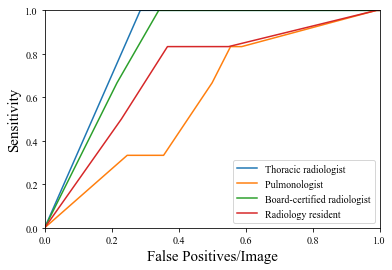

In [8]:
mapping_df = pd.read_csv('./data/brmh_1_mapping_table_respiratory.csv')
mapping_cases = mapping_df['case_no'].tolist()
group = ['Thoracic radiologist', 'Pulmonologist ', 'Board-certified radiologist', 'Radiology resident']
group_num = 0
interest_list = []
for i in range(12):
    interest_list.append('u{}_u{}'.format(str(i+2),str(i+14)))

#interest_list = ['u2/t2']
# print(interest_list)

with open('jafroc_respiratory(opt_resp).txt', 'w') as csvfile:
    for interest_dir in interest_list:
        print(group[group_num])
        if interest_dir == 'u2_u14' or interest_dir == 'u5_u17' or interest_dir == 'u8_u20' or interest_dir == 'u11_u23':
            gt_masks = []
            human_masks = []
            resized_human_outputs = []
        for index, file_name in enumerate(mapping_cases):
            if file_name.split('-')[0] == 'B':
                hospital_name = 'brmh'
            elif file_name.split('-')[0] == 'K':
                hospital_name = 'kyuh'
            elif file_name.split('-')[0] == 'G':
                hospital_name = 'gugh'
            else:
                raise ValueError('invalid hospital name')

            json_root_path = 'D:/lunit/data/review_result_20200705/{}-A1/{}/respiratory'.format(hospital_name.upper(), hospital_name)
            json_file = os.path.join(json_root_path, (file_name+'.dcm.json'))

#             heatmap_root_path = '/storage2/ctr/original/cxr/external_validation/BRMH-GIL-KONYANG/{}/respiratory'.format(hospital_name)

            with open(json_file, "r") as f:
                data = json.load(f)

#             handler = dicom_handler.get_handler(os.path.join(heatmap_root_path, (file_name+'.dcm')), modality='CXR')
#             pixel_array = handler.pixels
#             pixel_array = (pixel_array * 255).astype(np.uint8)
            height, width = data['height'], data['width']
            pixel_array = np.zeros((height,width))

#             mca_list = ['Nodule / Mass', 'Consolidation', 'Pneumothorax']
#             mca_list = ['Nodule / Mass']
#             mca_list = ['Consolidation']
            mca_list = ['Pneumothorax']
            gt_masks.append(get_gt_final_mask(data))

            human_root_path = 'D:/lunit/data/cxr_opt_respiratory'
            human_json_name = str(mapping_df['seq'].tolist()[index]) + '.json'
            human_json_full = os.path.join(human_root_path, interest_dir, 'without_AI', human_json_name)
            with open(human_json_full, "r") as f:
                human_data = json.load(f)

            human_masks.append(get_human_output(pixel_array, human_data))

        new_shape = (512, 512)
        human_outputs = [cv2.resize(np.asarray(human_mask), new_shape, interpolation=cv2.INTER_NEAREST) for human_mask in human_masks]

        gt_masks = [gt_mask.astype(bool) for gt_mask in gt_masks]

        
        
#         print(len(gt_masks), len(human_outputs))
        if interest_dir == 'u4_u16' or interest_dir == 'u7_u19' or interest_dir == 'u10_u22' or interest_dir == 'u13_u25':
           
            for index, human_output in enumerate(human_outputs):
                resized_human_outputs.append(np.resize(human_output, gt_masks[index].shape))
#             print(len(resized_human_outputs), len(gt_masks))
            
            jafroc_value, neg_image_scores, pos_contour_scores,roi_cnt = metric_1.jafroc(resized_human_outputs, gt_masks)
            print("jafroc:\t{:.3f}".format(jafroc_value), file=csvfile)
            print("jafroc:\t{:.3f}".format(jafroc_value))
            
            jaf_ci = metric_1.bootstrap_jafroc_ci(resized_human_outputs, gt_masks, n_bootstraps=100, alpha=0.05, rng_seed=123)
            print(jaf_ci, file=csvfile)
            print(jaf_ci)

            FROC=pd.DataFrame(columns=['prob','TP','FP','sensitivity','image/FP'])
            FROC=FROC.append({'prob':1,'TP':'TP','FP':'FP','sensitivity':1.0,'image/FP':1.0},ignore_index=True)
            num = len(gt_masks)
            for prob in range(0,100,1):
                TP=0
                FP=0
                for TPP in pos_contour_scores:
                    for TPPP in TPP:
                        if prob <= float(TPPP)*100:
                            TP=TP+1
                for FPP in neg_image_scores:
    #                 for FPPP in FPP:
                    if prob <= float(FPP)*100:
                        FP=FP+1
                #print(TP)
                imgFP=float(FP/float(num))
                sensitivity=float(TP/float(roi_cnt))
            #print(sensitivity)
                FROC=FROC.append({'prob':prob,'TP':TP,'FP':FP,'sensitivity':sensitivity,'image/FP':imgFP},ignore_index=True)
            
#             fig = plt.figure()
            FROC=FROC.append({'prob':0,'TP':'TP','FP':'FP','sensitivity':0,'image/FP':0},ignore_index=True)
            plt.xlabel('False Positives/Image', fontsize=15)
            plt.ylabel('Sensitivity', fontsize=15)  
            #fig.suptitle('Free response receiver operating characteristic curve', fontsize=12)
            plt.plot(FROC['image/FP'], FROC['sensitivity'],label='%s'%(group[group_num]))#, '-', color='#000000')    
            plt.legend(loc='lower right')
            plt.axis([0,1,0,1])
            group_num+=1


    plt.savefig("./jafroc/pneumothorax_withoutAI_jafroc_respiratory.tif",dpi=300)
    plt.show()
    
    
        
csvfile.close()

Thoracic radiologist
Thoracic radiologist
Thoracic radiologist
jafroc:	0.846
(0.829, 0.862)
Pulmonologist 
Pulmonologist 
Pulmonologist 
jafroc:	0.860
(0.843, 0.875)
Board-certified radiologist
Board-certified radiologist
Board-certified radiologist
jafroc:	0.819
(0.649, 0.884)
Radiology resident
Radiology resident
Radiology resident
jafroc:	0.820
(0.739, 0.868)


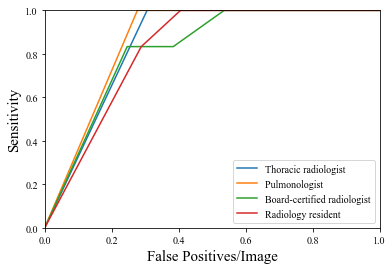

In [9]:
mapping_df = pd.read_csv('./data/brmh_1_mapping_table_respiratory.csv')
mapping_cases = mapping_df['case_no'].tolist()
group = ['Thoracic radiologist', 'Pulmonologist ', 'Board-certified radiologist', 'Radiology resident']
group_num = 0
interest_list = []
for i in range(12):
    interest_list.append('u{}_u{}'.format(str(i+2),str(i+14)))

#interest_list = ['u2/t2']
# print(interest_list)

with open('jafroc_respiratory(opt_resp).txt', 'w') as csvfile:
    for interest_dir in interest_list:
        print(group[group_num])
        if interest_dir == 'u2_u14' or interest_dir == 'u5_u17' or interest_dir == 'u8_u20' or interest_dir == 'u11_u23':
            gt_masks = []
            human_masks = []
            resized_human_outputs = []
        for index, file_name in enumerate(mapping_cases):
            if file_name.split('-')[0] == 'B':
                hospital_name = 'brmh'
            elif file_name.split('-')[0] == 'K':
                hospital_name = 'kyuh'
            elif file_name.split('-')[0] == 'G':
                hospital_name = 'gugh'
            else:
                raise ValueError('invalid hospital name')

            json_root_path = 'D:/lunit/data/review_result_20200705/{}-A1/{}/respiratory'.format(hospital_name.upper(), hospital_name)
            json_file = os.path.join(json_root_path, (file_name+'.dcm.json'))

#             heatmap_root_path = '/storage2/ctr/original/cxr/external_validation/BRMH-GIL-KONYANG/{}/respiratory'.format(hospital_name)

            with open(json_file, "r") as f:
                data = json.load(f)

#             handler = dicom_handler.get_handler(os.path.join(heatmap_root_path, (file_name+'.dcm')), modality='CXR')
#             pixel_array = handler.pixels
#             pixel_array = (pixel_array * 255).astype(np.uint8)
            height, width = data['height'], data['width']
            pixel_array = np.zeros((height,width))

#             mca_list = ['Nodule / Mass', 'Consolidation', 'Pneumothorax']
#             mca_list = ['Nodule / Mass']
#             mca_list = ['Consolidation']
            mca_list = ['Pneumothorax']
            gt_masks.append(get_gt_final_mask(data))

            human_root_path = 'D:/lunit/data/cxr_opt_respiratory'
            human_json_name = str(mapping_df['seq'].tolist()[index]) + '.json'
            human_json_full = os.path.join(human_root_path, interest_dir, 'with_AI', human_json_name)
            with open(human_json_full, "r") as f:
                human_data = json.load(f)

            human_masks.append(get_human_output(pixel_array, human_data))

        new_shape = (512, 512)
        human_outputs = [cv2.resize(np.asarray(human_mask), new_shape, interpolation=cv2.INTER_NEAREST) for human_mask in human_masks]

        gt_masks = [gt_mask.astype(bool) for gt_mask in gt_masks]

        
        
#         print(len(gt_masks), len(human_outputs))
        if interest_dir == 'u4_u16' or interest_dir == 'u7_u19' or interest_dir == 'u10_u22' or interest_dir == 'u13_u25':
           
            for index, human_output in enumerate(human_outputs):
                resized_human_outputs.append(np.resize(human_output, gt_masks[index].shape))
#             print(len(resized_human_outputs), len(gt_masks))
            
            jafroc_value, neg_image_scores, pos_contour_scores,roi_cnt = metric_1.jafroc(resized_human_outputs, gt_masks)
            print("jafroc:\t{:.3f}".format(jafroc_value), file=csvfile)
            print("jafroc:\t{:.3f}".format(jafroc_value))
            
            jaf_ci = metric_1.bootstrap_jafroc_ci(resized_human_outputs, gt_masks, n_bootstraps=100, alpha=0.05, rng_seed=123)
            print(jaf_ci, file=csvfile)
            print(jaf_ci)

            FROC=pd.DataFrame(columns=['prob','TP','FP','sensitivity','image/FP'])
            FROC=FROC.append({'prob':'prob','TP':'TP','FP':'FP','sensitivity':1.0,'image/FP':1.0},ignore_index=True)
            num = len(gt_masks)
            for prob in range(0,100,1):
                TP=0
                FP=0
                for TPP in pos_contour_scores:
                    for TPPP in TPP:
                        if prob <= float(TPPP)*100:
                            TP=TP+1
                for FPP in neg_image_scores:
    #                 for FPPP in FPP:
                    if prob <= float(FPP)*100:
                        FP=FP+1
                #print(TP)
                imgFP=float(FP/float(num))
                sensitivity=float(TP/float(roi_cnt))
            #print(sensitivity)
                FROC=FROC.append({'prob':prob,'TP':TP,'FP':FP,'sensitivity':sensitivity,'image/FP':imgFP},ignore_index=True)
            
#             fig = plt.figure()
            FROC=FROC.append({'prob':'prob','TP':'TP','FP':'FP','sensitivity':0,'image/FP':0},ignore_index=True)
            plt.xlabel('False Positives/Image', fontsize=15)
            plt.ylabel('Sensitivity', fontsize=15)  
            #fig.suptitle('Free response receiver operating characteristic curve', fontsize=12)
            plt.plot(FROC['image/FP'], FROC['sensitivity'],label='%s'%(group[group_num]))#, '-', color='#000000')    
            plt.legend(loc='lower right')
            plt.axis([0,1,0,1])
            group_num+=1


    plt.savefig("./jafroc/pneumothorax_withAI_jafroc_respiratory.tif",dpi=300)
    plt.show()
    
    
        
csvfile.close()

['u2_u11', 'u3_u12', 'u4_u13', 'u5_u14', 'u6_u15', 'u7_u16', 'u8_u17', 'u9_u18', 'u10_u19']
Thoracic radiologist
Thoracic radiologist
Thoracic radiologist
jafroc:	0.685
(0.57, 0.892)
12 1428
Board-certified radiologist
Board-certified radiologist
Board-certified radiologist
jafroc:	0.688
(0.518, 0.85)
12 1428
Radiology resident
Radiology resident
Radiology resident
jafroc:	0.688
(0.555, 0.833)
12 1428


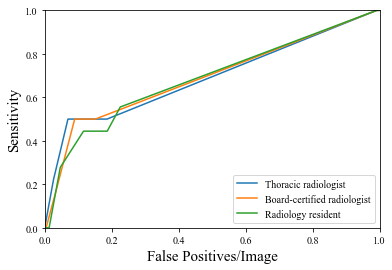

In [11]:
mapping_df = pd.read_csv('./data/brmh_2_mapping_table_healthcheck.csv')
mapping_cases = mapping_df['case_no'].tolist()
group = ['Thoracic radiologist', 'Board-certified radiologist', 'Radiology resident']
group_num = 0

interest_list = []
for i in range(9):
    interest_list.append('u{}_u{}'.format(str(i+2),str(i+11)))

#interest_list = ['u2/t2']
print(interest_list)


with open('jafroc_respiratory(opt_health).txt', 'w') as csvfile:
    for interest_dir in interest_list:
        print(group[group_num])
        if interest_dir == 'u2_u11' or interest_dir == 'u5_u14' or interest_dir == 'u8_u17':
            gt_masks = []
            human_masks = []
            resized_human_outputs = []
        for index, file_name in enumerate(mapping_cases):
            if file_name.split('-')[0] == 'B':
                hospital_name = 'brmh'
            elif file_name.split('-')[0] == 'K':
                hospital_name = 'kyuh'
            elif file_name.split('-')[0] == 'G':
                hospital_name = 'gugh'
            else:
                raise ValueError('invalid hospital name')

            json_root_path = 'D:/lunit/data/review_result_20200705/{}-A2/{}/healthcheck'.format(hospital_name.upper(), hospital_name)
            json_file = os.path.join(json_root_path, (file_name+'.dcm.json'))

#             heatmap_root_path = '/storage2/ctr/original/cxr/external_validation/BRMH-GIL-KONYANG/{}/respiratory'.format(hospital_name)

            with open(json_file, "r") as f:
                data = json.load(f)

#             handler = dicom_handler.get_handler(os.path.join(heatmap_root_path, (file_name+'.dcm')), modality='CXR')
#             pixel_array = handler.pixels
#             pixel_array = (pixel_array * 255).astype(np.uint8)
            height, width = data['height'], data['width']
            pixel_array = np.zeros((height,width))

#             mca_list = ['Nodule / Mass', 'Consolidation', 'Pneumothorax']
#             mca_list = ['Nodule / Mass']
            mca_list = ['Consolidation']
#             mca_list = ['Pneumothorax']
            gt_masks.append(get_gt_final_mask(data))

            human_root_path = 'D:/lunit/data/cxr_opt_healthcheck'
            human_json_name = str(mapping_df['seq'].tolist()[index]) + '.json'
            human_json_full = os.path.join(human_root_path, interest_dir, 'without_AI', human_json_name)
            with open(human_json_full, "r") as f:
                human_data = json.load(f)

            human_masks.append(get_human_output(pixel_array, human_data))

        new_shape = (512, 512)
        human_outputs = [cv2.resize(np.asarray(human_mask), new_shape, interpolation=cv2.INTER_NEAREST) for human_mask in human_masks]

        gt_masks = [gt_mask.astype(bool) for gt_mask in gt_masks]

        
        
#         print(len(gt_masks), len(human_outputs))
        if interest_dir == 'u4_u13' or interest_dir == 'u7_u16' or interest_dir == 'u10_u19':
           
            for index, human_output in enumerate(human_outputs):
                resized_human_outputs.append(np.resize(human_output, gt_masks[index].shape))
#             print(len(resized_human_outputs), len(gt_masks))
            
            jafroc_value, neg_image_scores, pos_contour_scores,roi_cnt = metric_1.jafroc(resized_human_outputs, gt_masks)
            print("jafroc:\t{:.3f}".format(jafroc_value), file=csvfile)
            print("jafroc:\t{:.3f}".format(jafroc_value))
            
            jaf_ci = metric_1.bootstrap_jafroc_ci(resized_human_outputs, gt_masks, n_bootstraps=100, alpha=0.05, rng_seed=123)
            print(jaf_ci, file=csvfile)
            print(jaf_ci)

            FROC=pd.DataFrame(columns=['prob','TP','FP','sensitivity','image/FP'])
            FROC=FROC.append({'prob':'prob','TP':'TP','FP':'FP','sensitivity':1.0,'image/FP':1.0},ignore_index=True)
            num = len(gt_masks)
            print(len(pos_contour_scores),len(neg_image_scores))
            for prob in range(0,100,1):
                TP=0
                FP=0
                for TPP in pos_contour_scores:
                    for TPPP in TPP:
                        if prob <= float(TPPP)*100:
                            TP=TP+1
                for FPP in neg_image_scores:
    #                 for FPPP in FPP:
                    if prob <= float(FPP)*100:
                        FP=FP+1
                #print(TP)
                imgFP=float(FP/float(num))
                sensitivity=float(TP/float(roi_cnt))
            #print(sensitivity)
                FROC=FROC.append({'prob':prob,'TP':TP,'FP':FP,'sensitivity':sensitivity,'image/FP':imgFP},ignore_index=True)
            
#             fig = plt.figure()
            FROC=FROC.append({'prob':'prob','TP':'TP','FP':'FP','sensitivity':0,'image/FP':0},ignore_index=True)
            plt.xlabel('False Positives/Image', fontsize=15)
            plt.ylabel('Sensitivity', fontsize=15)  
            #fig.suptitle('Free response receiver operating characteristic curve', fontsize=12)
            plt.plot(FROC['image/FP'], FROC['sensitivity'],label='%s'%(group[group_num]))#, '-', color='#000000')    
            plt.legend(loc='lower right')
            plt.axis([0,1,0,1])
            group_num+=1


    plt.savefig("./jafroc/consolidation_withoutAI_jafroc_healthcheck.tif",dpi=300)
    plt.show()
    
    
        
csvfile.close()

['u2_u11', 'u3_u12', 'u4_u13', 'u5_u14', 'u6_u15', 'u7_u16', 'u8_u17', 'u9_u18', 'u10_u19']
Thoracic radiologist
Thoracic radiologist
Thoracic radiologist
jafroc:	0.673
(0.558, 0.873)
12 1428
Board-certified radiologist
Board-certified radiologist
Board-certified radiologist
jafroc:	0.737
(0.602, 0.892)
12 1428
Radiology resident
Radiology resident
Radiology resident
jafroc:	0.703
(0.546, 0.891)
12 1428


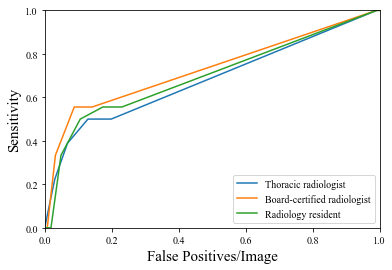

In [12]:
mapping_df = pd.read_csv('./data/brmh_2_mapping_table_healthcheck.csv')
mapping_cases = mapping_df['case_no'].tolist()
group = ['Thoracic radiologist', 'Board-certified radiologist', 'Radiology resident']
group_num = 0

interest_list = []
for i in range(9):
    interest_list.append('u{}_u{}'.format(str(i+2),str(i+11)))

#interest_list = ['u2/t2']
print(interest_list)


with open('jafroc_respiratory(opt_health).txt', 'w') as csvfile:
    for interest_dir in interest_list:
        print(group[group_num])
        if interest_dir == 'u2_u11' or interest_dir == 'u5_u14' or interest_dir == 'u8_u17':
            gt_masks = []
            human_masks = []
            resized_human_outputs = []
        for index, file_name in enumerate(mapping_cases):
            if file_name.split('-')[0] == 'B':
                hospital_name = 'brmh'
            elif file_name.split('-')[0] == 'K':
                hospital_name = 'kyuh'
            elif file_name.split('-')[0] == 'G':
                hospital_name = 'gugh'
            else:
                raise ValueError('invalid hospital name')

            json_root_path = 'D:/lunit/data/review_result_20200705/{}-A2/{}/healthcheck'.format(hospital_name.upper(), hospital_name)
            json_file = os.path.join(json_root_path, (file_name+'.dcm.json'))

#             heatmap_root_path = '/storage2/ctr/original/cxr/external_validation/BRMH-GIL-KONYANG/{}/respiratory'.format(hospital_name)

            with open(json_file, "r") as f:
                data = json.load(f)

#             handler = dicom_handler.get_handler(os.path.join(heatmap_root_path, (file_name+'.dcm')), modality='CXR')
#             pixel_array = handler.pixels
#             pixel_array = (pixel_array * 255).astype(np.uint8)
            height, width = data['height'], data['width']
            pixel_array = np.zeros((height,width))

#             mca_list = ['Nodule / Mass', 'Consolidation', 'Pneumothorax']
#             mca_list = ['Nodule / Mass']
            mca_list = ['Consolidation']
#             mca_list = ['Pneumothorax']
            gt_masks.append(get_gt_final_mask(data))

            human_root_path = 'D:/lunit/data/cxr_opt_healthcheck'
            human_json_name = str(mapping_df['seq'].tolist()[index]) + '.json'
            human_json_full = os.path.join(human_root_path, interest_dir, 'with_AI', human_json_name)
            with open(human_json_full, "r") as f:
                human_data = json.load(f)

            human_masks.append(get_human_output(pixel_array, human_data))

        new_shape = (512, 512)
        human_outputs = [cv2.resize(np.asarray(human_mask), new_shape, interpolation=cv2.INTER_NEAREST) for human_mask in human_masks]

        gt_masks = [gt_mask.astype(bool) for gt_mask in gt_masks]

        
        
#         print(len(gt_masks), len(human_outputs))
        if interest_dir == 'u4_u13' or interest_dir == 'u7_u16' or interest_dir == 'u10_u19':
           
            for index, human_output in enumerate(human_outputs):
                resized_human_outputs.append(np.resize(human_output, gt_masks[index].shape))
#             print(len(resized_human_outputs), len(gt_masks))
            
            jafroc_value, neg_image_scores, pos_contour_scores,roi_cnt = metric_1.jafroc(resized_human_outputs, gt_masks)
            print("jafroc:\t{:.3f}".format(jafroc_value), file=csvfile)
            print("jafroc:\t{:.3f}".format(jafroc_value))
            
            jaf_ci = metric_1.bootstrap_jafroc_ci(resized_human_outputs, gt_masks, n_bootstraps=100, alpha=0.05, rng_seed=123)
            print(jaf_ci, file=csvfile)
            print(jaf_ci)

            FROC=pd.DataFrame(columns=['prob','TP','FP','sensitivity','image/FP'])
            FROC=FROC.append({'prob':'prob','TP':'TP','FP':'FP','sensitivity':1.0,'image/FP':1.0},ignore_index=True)
            num = len(gt_masks)
            print(len(pos_contour_scores),len(neg_image_scores))
            for prob in range(0,100,1):
                TP=0
                FP=0
                for TPP in pos_contour_scores:
                    for TPPP in TPP:
                        if prob <= float(TPPP)*100:
                            TP=TP+1
                for FPP in neg_image_scores:
    #                 for FPPP in FPP:
                    if prob <= float(FPP)*100:
                        FP=FP+1
                #print(TP)
                imgFP=float(FP/float(num))
                sensitivity=float(TP/float(roi_cnt))
            #print(sensitivity)
                FROC=FROC.append({'prob':prob,'TP':TP,'FP':FP,'sensitivity':sensitivity,'image/FP':imgFP},ignore_index=True)
            
#             fig = plt.figure()
            FROC=FROC.append({'prob':'prob','TP':'TP','FP':'FP','sensitivity':0,'image/FP':0},ignore_index=True)
            plt.xlabel('False Positives/Image', fontsize=15)
            plt.ylabel('Sensitivity', fontsize=15)  
            #fig.suptitle('Free response receiver operating characteristic curve', fontsize=12)
            plt.plot(FROC['image/FP'], FROC['sensitivity'],label='%s'%(group[group_num]))#, '-', color='#000000')    
            plt.legend(loc='lower right')
            plt.axis([0,1,0,1])
            group_num+=1


    plt.savefig("./jafroc/consolidation_withAI_jafroc_healthcheck.tif",dpi=300)
    plt.show()
    
    
        
csvfile.close()